In [1]:
import sys
sys.path.append('..')

In [2]:
import re
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from myutils.matplotlib import matplotlib_seaborn_style

from src.missing_values import impute_average
from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/preprocessing')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

## Базовая реструктуризация данных

В этой части сырые данные (в том виде, в котором их Ваня присылает) немного чистятся и форматируются:

1. Удаляются поезда, для которых соответствующие файлы (по местам и ценам) содержат сплошные нули. Это связано с тем, что у Вани есть файл по каждой паре "номер поезда" — "класс обслуживания", даже если такого класса в таком поезде вовсе нет.
2. Удаляются даты, за которые за весь период вообще не было ни одного билета.

## Препроцессинг

Тут уже работаем с первично почищенными данными.

In [4]:
data = pd.read_csv('../data/raw_data/data.csv', parse_dates=['date'], encoding='utf-8')

data.head(2)

,date,days,places,price,num,class,train
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе


In [5]:
data['train'].nunique()

144

### Добавляем данные о времени отправления и прибытия

In [6]:
train_timetable = pd.read_csv('../data/train_timetable.csv')

train_timetable.head(2)

,num,departure_time,travel_time
0,701Н,07:45,03:52
1,703Н,11:05,03:55


In [7]:
def to_hour(time: str) -> int:
    hour, minute = time.split(':')
    hour = int(hour)
    minute = int(minute)
    
    # timestamp = (hour * 60 + minute) * 60
    hour = hour + minute / 60
        
    return hour


train_timetable['departure_hour'] = train_timetable['departure_time'].apply(to_hour)
train_timetable['arrival_hour'] = (train_timetable['departure_hour'] \
    + train_timetable['travel_time'].apply(to_hour)) % 24

train_timetable.head(2)

,num,departure_time,travel_time,departure_hour,arrival_hour
0,701Н,07:45,03:52,7.750000,11.616667
1,703Н,11:05,03:55,11.083333,15.000000


In [8]:
data = data.merge(
    train_timetable[['num', 'departure_hour', 'arrival_hour']],
    on='num',
    how='left',
)

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


In [9]:
data.loc[data['departure_hour'].isna(), 'num'].unique()

array([], dtype=object)

### Удаляем данные за праздники (29 апреля — 12 мая)

In [10]:
holidays = np.arange(
    datetime(year=2021, month=4, day=29),
    datetime(year=2021, month=5, day=13),
    timedelta(days=1),
)

data = data[~data['date'].isin(holidays)].copy()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,23.916667,7.916667
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,23.916667,7.916667


### Заполненность строк для разных поездов

Для каждой тройки "поезд" — "класс" — "дата отправления" смотрим долю заполненных значений за последние 30 дней до отправления.

In [11]:
dates = data['date'].drop_duplicates().sort_values().values

# айдишник позиции, на которой происходит удаление майских праздников
split_id = np.where(dates > holidays[-1])[0][0]

In [12]:
def date_formatter(dt: datetime) -> str:
    return dt.strftime('%b %d (%a)')

In [13]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)

filled_frac.head(2)

,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2021-04-04,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,...,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667


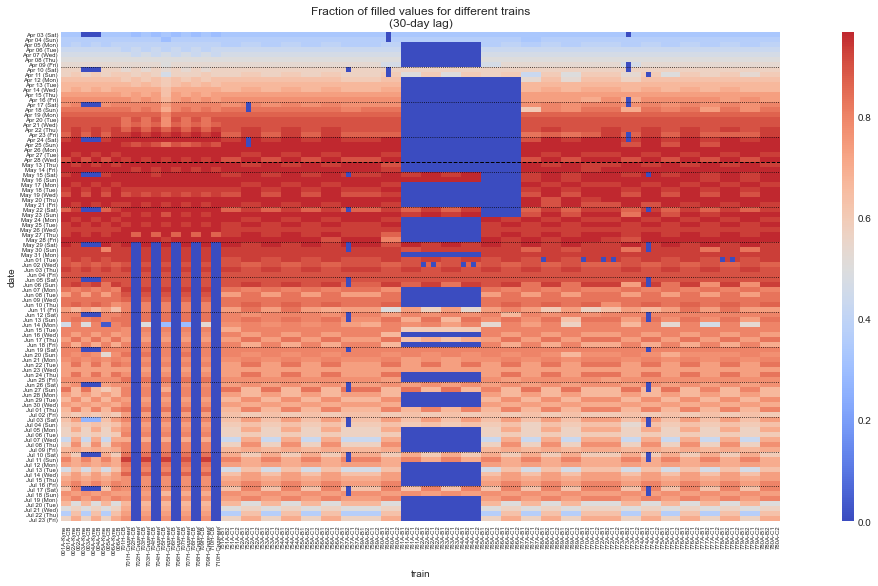

In [14]:
filled_frac_ = filled_frac.copy()
filled_frac_.index = filled_frac_.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac_, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig(figures_dir / 'filled_frac.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Удаляем отдельные поезда, для которых уж больно много полных пропусков.

In [15]:
train_nums_to_remove = ['761А', '762А', '763А', '764А', '765А', '766А', '702Н', '704Н', '706Н', '708Н', '710Н']

mask = data['num'].isin(train_nums_to_remove)
data = data[~mask].copy()

mask.sum(), data['train'].nunique()

(78026, 110)

Удаляем все кейсы, в которых значение в клетке меньше `0.6`.

In [16]:
filled_frac_melt = filled_frac.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='filled_frac')

filled_frac_melt.head(2)

,date,train,filled_frac
0,2021-04-03,001А-Купе,0.333333
1,2021-04-04,001А-Купе,0.366667


In [17]:
to_remove = filled_frac_melt.loc[filled_frac_melt['filled_frac'] <= 0.6, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

print(to_remove.apply(len).sum())

to_remove.head(2)

3962


train
001А-Купе    [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
001А-СВ      [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
Name: date, dtype: object

In [18]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/144 [00:00<?, ?it/s]

110

Отрисовываем, что получилось после чистки.

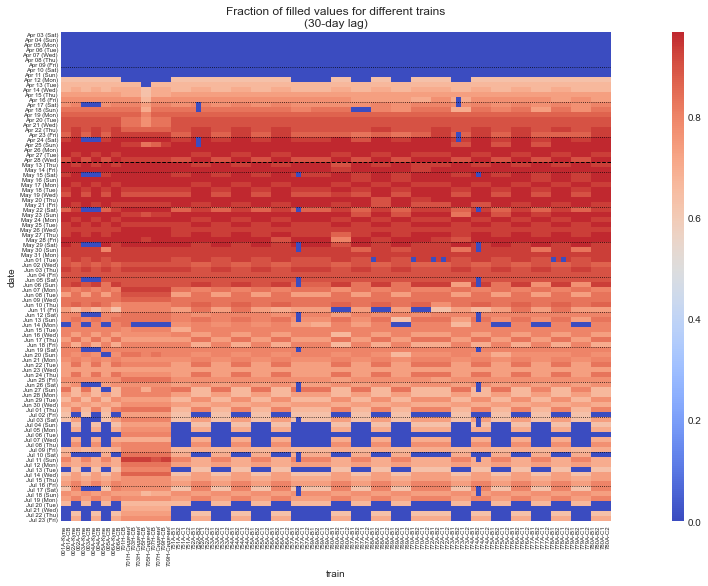

In [19]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig(figures_dir / 'filled_frac_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Вместимость каждого поезда в зависимости от даты

Тут считаем "вместимость" каждого поездо-класса в зависимости от даты. Как это делается:

1. Считаем максимальное число свободных мест для каждой тройки "поезд" — "класс" — "дата" в течение всех дней до отправления.
2. Делим это число на максимум по всем датам для конкретного поездо-класса.

Суть: если разброс этих значений сильно большой (белые пятна на картинке ниже), это свидетельствует о том, что количество вагонов для конкретного поездо-класса менялось извне (руками РЖД). Такие кейсы надо то ли обрабатывать отдельно, то ли выкидывать вовсе, короче они не применимы.

In [20]:
capacity = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity /= capacity.max()

capacity.head(2)

train,001А-Купе,001А-СВ,002А-Купе,002А-СВ,003А-Купе,003А-СВ,004А-Купе,004А-СВ,005А-Купе,005А-СВ,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


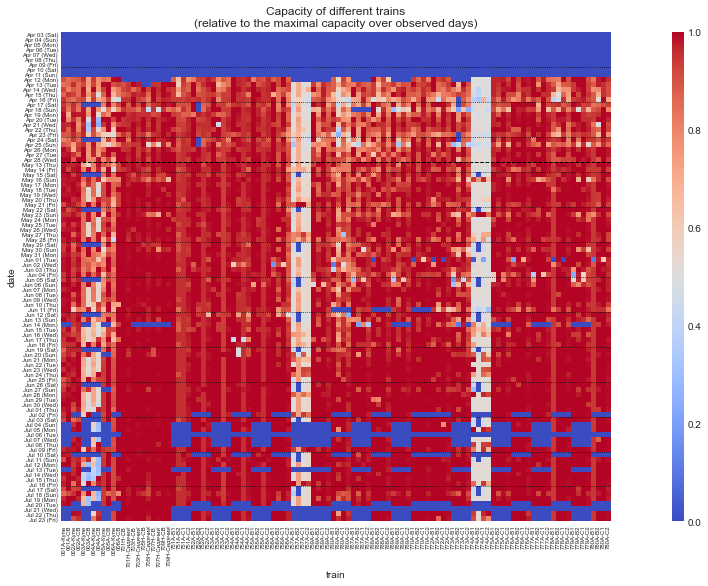

In [21]:
capacity_ = capacity.copy()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(capacity_, ax=ax, square=True, center=0.5, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig(figures_dir / 'capacity.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Удаляем поезда, для которых слишком много белых пятен в принципе.

In [22]:
train_nums_to_remove = ['003А', '004А', '757А', '774А']

mask = data['num'].isin(train_nums_to_remove)

data = data[~mask].copy()

mask.sum()

50887

Удаляем отдельные клетки, значение в которых меньше `0.7`.

In [23]:
capacity_melt = capacity.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='capacity')

capacity_melt.head(2)

,date,train,capacity
0,2021-04-03,001А-Купе,0.0
1,2021-04-04,001А-Купе,0.0


In [24]:
to_remove = capacity_melt.loc[capacity_melt['capacity'] <= 0.7, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

print(to_remove.apply(len).sum())

to_remove.head(2)

2651


train
001А-Купе    [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
001А-СВ      [2021-04-03T00:00:00.000000000, 2021-04-04T00:...
Name: date, dtype: object

In [25]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/110 [00:00<?, ?it/s]

98

Смотрим, что получилось.

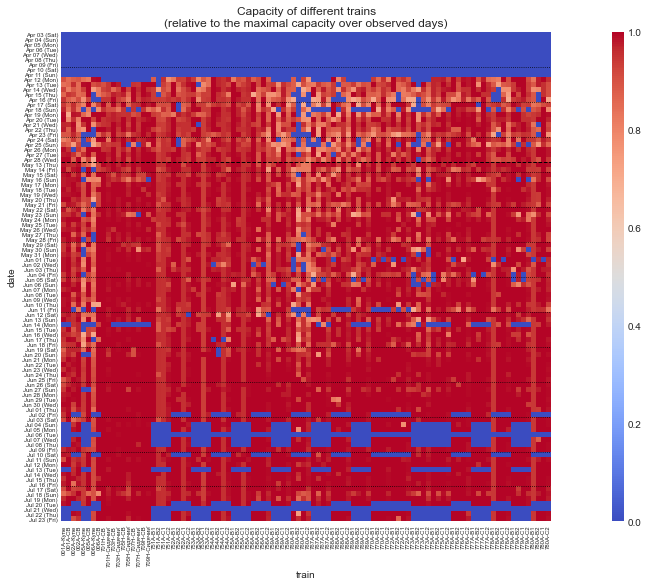

In [26]:
capacity_ = data.groupby(['train', 'date'])['places'].max().reset_index()\
    .pivot(index='date', columns='train', values='places')\
    .reindex(dates).fillna(0)
capacity_ /= capacity_.max()
capacity_.index = capacity_.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(capacity_, ax=ax, square=True, center=0.5, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, capacity_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Capacity of different trains\n'
             '(relative to the maximal capacity over observed days)')

plt.savefig(figures_dir / 'capacity_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

### Смотрим данные по дням недели (только число билетов)

In [27]:
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

weekdays

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [28]:
trains = data['train'].drop_duplicates().sort_values().values
len(trains)

98

(Картинка слишком здоровая, поэтому тут не отрисовывается.)

In [29]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'places_vs_weekday_raw.pdf', transparent=True, bbox_inches='tight')
plt.close()

No handles with labels found to put in legend.


Судя по картинке, всё ещё осталось несколько поездов, в которых число вагонов явно увеличивалось извне (т.е. со стороны РЖД) в ходе приближения даты отправления. Выкидываем.

In [30]:
trains_to_remove = ['001А-СВ', '002А-СВ', '005А-Купе', '006А-Купе']

data = data[~data['train'].isin(trains_to_remove)].copy()

In [31]:
trains = sorted(data['train'].unique().tolist())
len(trains)

94

Для каждой тройки "поезд" — "класс" — "дата" считаем максимум модуля разности между соседними значениями (в течение всех дней до отправления).

In [32]:
for train in data['train'].unique():
    mask = data['train'] == train
    data.loc[mask, 'places_frac'] = data.loc[mask, 'places'] / data.loc[mask, 'places'].max()
    
data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,weekday,day_name,places_frac
9,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0,Monday,0.200000
10,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,1,Tuesday,0.371429


In [33]:
max_step = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    max_step[train] = (places_frac - places_frac.shift(axis=1)).abs().max(axis=1)
    
max_step = pd.DataFrame(max_step).reindex(dates)

max_step.tail(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,703Н-СВ,703Н-Сидячий,705Н-СВ,705Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-07-22,NaN,0.027778,NaN,0.178571,0.095238,0.031339,0.047619,0.022792,0.047619,0.054131,...,0.022727,0.043243,NaN,NaN,NaN,NaN,0.055556,0.061224,0.045455,0.051351
2021-07-23,NaN,0.069444,NaN,0.178571,0.166667,0.142450,0.047619,0.111111,0.142857,0.082621,...,0.113636,0.083784,NaN,NaN,NaN,NaN,0.277778,0.081633,0.090909,0.054054


Белые/красные точки — кейсы, когда за один день было куплено/возвращено более 50% билетов.

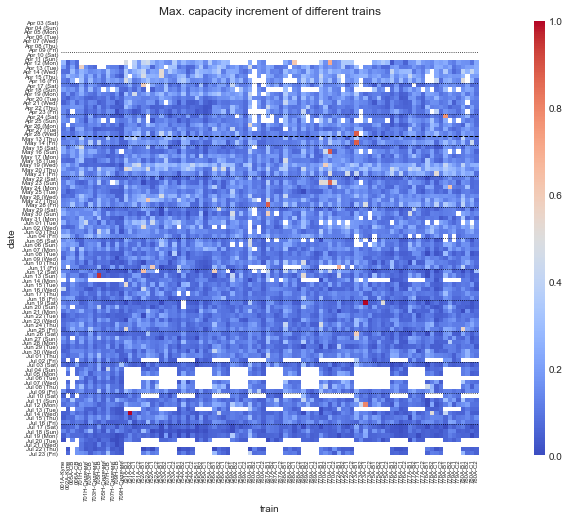

In [34]:
max_step_ = max_step.copy()
max_step_.index = max_step_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(max_step_, ax=ax, center=0.5, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, max_step_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Max. capacity increment of different trains')

plt.savefig(figures_dir / 'max_capacity_increment.pdf', transparent=True, bbox_inches='tight')
# plt.close()

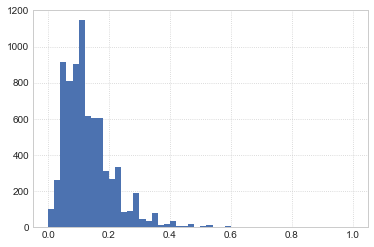

In [35]:
vals = max_step.values.flatten()
vals = vals[~np.isnan(vals)]

plt.hist(vals, bins=50);

In [36]:
q1, q2, q3 = np.quantile(vals, [0.25, 0.5, 0.75])
iqr = q3 - q1

thres = q3 + 1.5 * iqr

thres, (vals >= thres).sum(), (vals >= thres).mean()

(0.3285993768567496, 236, 0.031308039267710266)

По "боксплоту" удаляем экстремальные значения.

In [37]:
max_step_melt = max_step.reset_index()\
    .melt(id_vars='date', var_name='train', value_name='max_step')

max_step_melt.head(2)

,date,train,max_step
0,2021-04-03,001А-Купе,NaN
1,2021-04-04,001А-Купе,NaN


In [38]:
to_remove = max_step_melt.loc[max_step_melt['max_step'] >= thres, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

to_remove.head(2)

train
001А-Купе    [2021-06-16T00:00:00.000000000]
005А-СВ      [2021-06-07T00:00:00.000000000]
Name: date, dtype: object

In [39]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/66 [00:00<?, ?it/s]

94

Смотрим, что получилось.

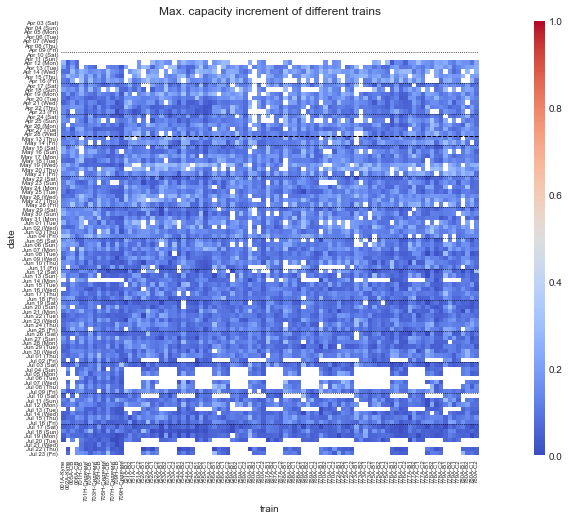

In [40]:
max_step_ = {}

for train in data['train'].unique():
    places_frac = data[data['train'] == train].pivot(index='date', columns='days', values='places_frac')
    max_step_[train] = (places_frac - places_frac.shift(axis=1)).abs().max(axis=1)
    
max_step_ = pd.DataFrame(max_step_).reindex(dates)

max_step_.index = max_step_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(max_step_, ax=ax, vmin=0, vmax=1, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, max_step_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Max. capacity increment of different trains')

plt.savefig(figures_dir / 'max_capacity_increment_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [41]:
trains = sorted(data['train'].unique().tolist())

len(trains)

94

Ещё раз рисуем данные по дням недели. Здесь удалены поезда с:

* меняющейся вместимостью,
* слишком большим разбросом числа свободных мест.

Но, как мы увидим, мусор всё же есть.

In [42]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'places_vs_weekday_interm.pdf', transparent=True, bbox_inches='tight')
plt.close()

No handles with labels found to put in legend.


### Выбросы по значениям ГК

Наконец, чтобы удалить оставшиеся выбросы, строим модель PCA с одной ГК и используем значения этой ГК для каждого поезда.

_Замечание._ Да, непосредственно значения ГК на данных с выбросами анализировать некорректно, но хотя бы пики можно по ним отслеживать.

Здесь `PlacePriceModel` — модель, соответствующая уравнениям:

$$\begin{cases} n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\ C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau) \end{cases},$$

где $n(t, \tau)$ — число свободных мест и $C(t, \tau)$ — цена на поезд с отправлением в день $t$ за $\tau$ дней до отправления, $\mu(\tau)$ — среднее число свободных мест, $a(t)$ — главная компонента PCA, $V(\tau)$ — её ортогональная составляющая, $b_0$, $b_1$ — коэффициенты регрессии, $\delta(t, \tau)$, $\varepsilon(t, \tau)$ — ошибки PCA и линейной регрессии соответственно.

Вкратце: число свободных мест определяется по модели PCA, а зависимость цены от числа мест — линейной регрессией.

Вся эта модель нам тут не нужна, только PCA, но `PlacePriceModel` немного удобнее тут воспользоваться, потому что ей можно прямо таблички скормить.

In [43]:
maxdays = 60

In [44]:
models = {}
metrics = []

for train in tqdm(trains):
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel()
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.to_csv(results_dir / 'model_metrics.csv', index=False)

metrics.head(2)

  0%|          | 0/94 [00:00<?, ?it/s]

,num,class,explained,r2,train
0,001А,Купе,0.721965,0.038126,001А-Купе
1,002А,Купе,0.729611,0.058589,002А-Купе


<AxesSubplot:xlabel='explained', ylabel='r2'>

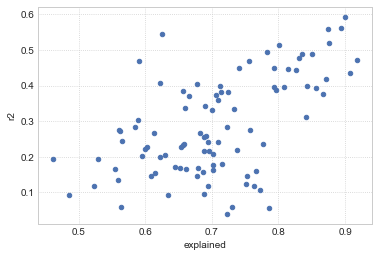

In [45]:
metrics.plot(kind='scatter', x='explained', y='r2')

Главные компоненты для всех пар "поезд" — "класс".

_Замечание._ Главные компоненты нормализованы, т.е. их среднее равно 0, а СКО равно 1.

In [46]:
a = pd.DataFrame({train: model.a for train, model in models.items()})

a.head(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,703Н-СВ,703Н-Сидячий,705Н-СВ,705Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,0.360311,0.985001,-0.096378,1.198494,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.204597,0.507909,0.410413,1.829760,0.620226,1.414263,-0.006656,2.449954,0.668729,1.390325
2021-04-13,0.069610,1.493876,0.798485,1.270716,NaN,0.48616,1.211104,1.516783,NaN,NaN,...,-2.232413,-0.058516,0.324868,1.044674,0.706172,1.088571,0.208556,2.506339,-0.203583,0.797493


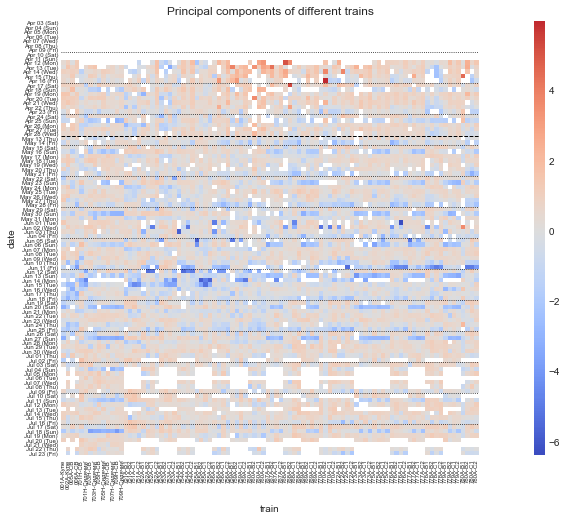

In [47]:
a_ = a.copy().reindex(dates)
a_.index = a_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(a_, ax=ax, center=0, square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, a_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Principal components of different trains')

plt.savefig(figures_dir / 'pcs.pdf', transparent=True, bbox_inches='tight')
# plt.close()

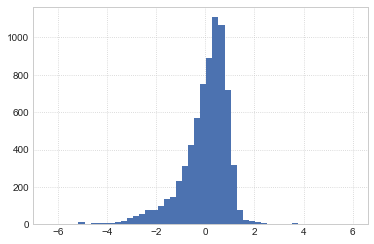

In [48]:
vals = a.values.flatten()
vals = vals[~np.isnan(vals)]

plt.hist(vals, bins=50);

Удаляем клетки, для которых значение ГК меньше `-3`.

In [49]:
thres = -3

thres, (vals <= thres).sum(), (vals <= thres).mean()

(-3, 106, 0.014516570802519857)

In [50]:
a_melt = a.fillna(-5).reset_index().melt(id_vars='date', var_name='train', value_name='pc')

a_melt.head(2)

,date,train,pc
0,2021-04-12,001А-Купе,0.360311
1,2021-04-13,001А-Купе,0.069610


In [51]:
to_remove = a_melt.loc[a_melt['pc'] <= thres, ['train', 'date']]\
    .groupby('train')['date'].apply(lambda s: s.unique())

to_remove.head(2)

train
001А-Купе    [2021-04-29T00:00:00.000000000, 2021-04-30T00:...
002А-Купе    [2021-04-26T00:00:00.000000000, 2021-04-29T00:...
Name: date, dtype: object

In [52]:
for train, dates_to_remove in tqdm(to_remove.iteritems(), total=len(to_remove)):
    mask = ((data['train'] == train) & data['date'].isin(dates_to_remove))
    data = data[~mask].copy()

data['train'].nunique()

  0%|          | 0/94 [00:00<?, ?it/s]

94

Смотрим, что получилось.

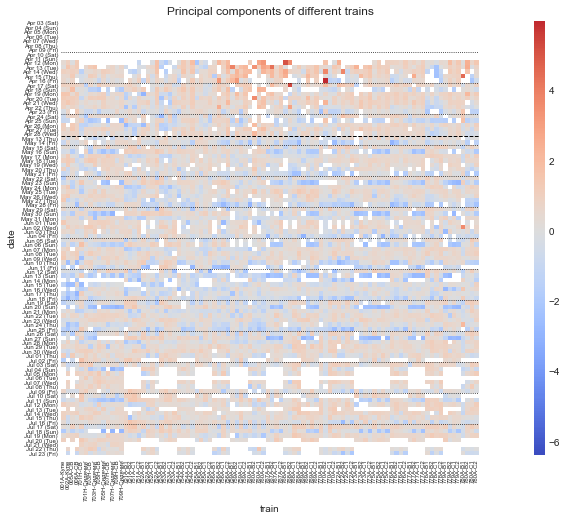

In [53]:
a_ = a_melt.pivot(index='date', columns='train', values='pc').reindex(dates)
a_.values[a_.values < thres] = np.nan
a_.index = a_.index.map(date_formatter)

ax = plt.figure(figsize=(20, 8)).gca()
sns.heatmap(a_, ax=ax, center=0, vmin=a.min().min(), square=True,
            xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, a_.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Principal components of different trains')

plt.savefig(figures_dir / 'pcs_clean.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Смотрим, что получилось на картинке по дням недели.

In [54]:
ncols = 9
nrows = len(trains) // ncols + (len(trains) % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
for i in range(1, nrows, 3):
    axes[(i + 1) * ncols - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(len(trains), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'places_vs_weekday_clean.pdf', transparent=True, bbox_inches='tight')
plt.close()

No handles with labels found to put in legend.


Наконец, смотрим, сколько данных у нас "осталось".

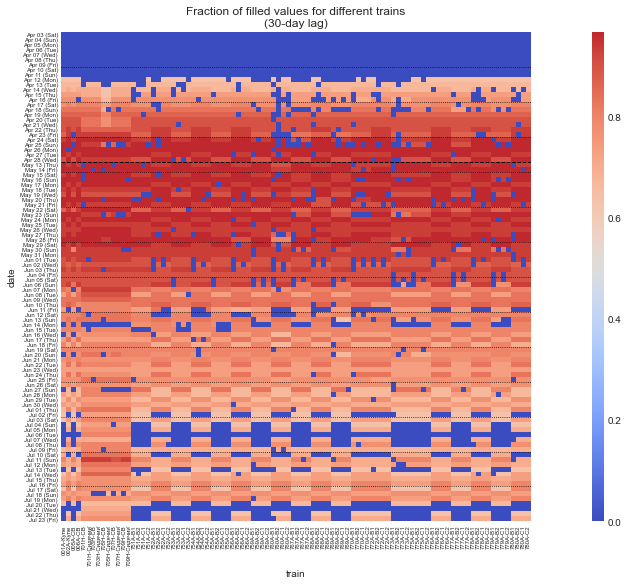

In [55]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 30)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(30-day lag)')

plt.savefig(figures_dir / 'filled_frac_final.pdf', transparent=True, bbox_inches='tight')
# plt.close()

То же за 60-дневный период до отправления.

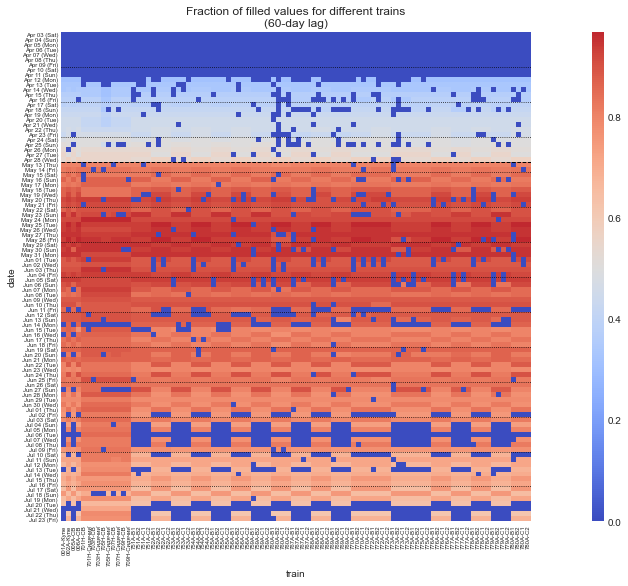

In [56]:
filled_frac = pd.DataFrame({
    train: data[(data['train'] == train) & (data['days'] <= 60)]\
                    .pivot(index='date', columns='days', values='places')\
                    .notna().mean(axis=1)
    for train in sorted(data['train'].unique())
}).reindex(dates).fillna(0)
filled_frac.index = filled_frac.index.map(date_formatter)

ax = plt.figure(figsize=(22, 9)).gca()
sns.heatmap(filled_frac, center=0.5, square=True, ax=ax, xticklabels=True, yticklabels=True,
            cmap='coolwarm', cbar_kws={'aspect': 40})

ax.axhline(split_id, c='k', ls='dashed', lw=1)

for i in np.arange(0, filled_frac.shape[0], 7)[1:]:
    ax.axhline(i, c='k', ls='dotted', lw=0.8)

ax.set_xlabel('train')
ax.tick_params(axis='both', which='major', labelsize=6)

ax.set_title('Fraction of filled values for different trains\n'
             '(60-day lag)')

plt.savefig(figures_dir / 'filled_frac_60day_final.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Сохраняем.

In [57]:
data.drop(columns=['weekday', 'day_name']).to_csv('../data/data.csv', index=False, encoding='utf-8')